In [1]:
# !rm *.csv*
# !git clone https://github.com/zhouhaoyi/Informer2020.git
# !wget https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv
# !wget https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh2.csv
!uv pip install --system "numpy<2" optuna optunahub

Using Python 3.11.13 environment at: /usr
Resolved 38 packages in 446ms                                        
⠙ Preparing packages... (0/3)                                                   
⠙ Preparing packages... (0/3)----     0 B/1.34 MiB                      
⠙ Preparing packages... (0/3)---- 16.00 KiB/1.34 MiB                    
⠙ Preparing packages... (0/3)---- 32.00 KiB/1.34 MiB                    
⠙ Preparing packages... (0/3)---- 48.00 KiB/1.34 MiB                    
⠙ Preparing packages... (0/3)---- 62.87 KiB/1.34 MiB                    
⠙ Preparing packages... (0/3)---- 78.87 KiB/1.34 MiB                    
⠙ Preparing packages... (0/3)---- 94.87 KiB/1.34 MiB                    
⠙ Preparing packages... (0/3)---- 110.87 KiB/1.34 MiB                   
⠙ Preparing packages... (0/3)---- 118.87 KiB/1.34 MiB                   
⠙ Preparing packages... (0/3)---- 126.87 KiB/1.34 MiB                   
optunahub  ------------------------------     0 B/12.07 KiB
⠙ Preparing packa

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MaxNLocator
import os, optuna
import torch
import numpy as np
from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend
import sys
if 'Informer2020' not in sys.path:
    sys.path += ['Informer2020']
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
OPENAI_Key_Sasha = user_secrets.get_secret("OPENAI_Key_Sasha")

ETTh1 = pd.read_csv('ETTh1.csv')
ETTh2 = pd.read_csv('ETTh2.csv')

## EDA

### Функции для EDA

In [5]:
def base_info(df1, df2, names=['DF1', 'DF2']):
    return pd.DataFrame({
        f'{names[0]}_type': df1.dtypes,
        f'{names[0]}_null': df1.isnull().sum(),
        f'{names[1]}_type': df2.dtypes,
        f'{names[1]}_null': df2.isnull().sum()
    })

def plot_timeseries(datasets, names):
    n_features = len(datasets[0].select_dtypes(include='number').columns)

    fig1, axes1 = plt.subplots(n_features, len(datasets),
                               figsize=(16, 3*n_features))
    if len(datasets) == 1:
        axes1 = axes1.reshape(-1, 1)
    elif n_features == 1:
        axes1 = axes1.reshape(1, -1)

    fig2, axes2 = plt.subplots(1, len(datasets), figsize=(16, 8))
    if len(datasets) == 1:
        axes2 = [axes2]

    for i, (df, name) in enumerate(zip(datasets, names)):
        # Используй колонку с датой как индекс
        date_col = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()][0]
        df_plot = df.set_index(pd.to_datetime(df[date_col]))
        numeric_cols = df_plot.select_dtypes(include='number').columns

        for j, col in enumerate(numeric_cols):
            axes1[j, i].plot(df_plot.index, df_plot[col])
            axes1[j, i].set_title(f'{name}: {col}')
            axes1[j, i].xaxis.set_major_locator(MaxNLocator(4))
            axes1[j, i].xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M'))
            axes1[j, i].tick_params(axis='x', rotation=45)

        sns.heatmap(df_plot.select_dtypes(include='number').corr(),
                   ax=axes2[i], annot=True, fmt='.2f', cbar=False)
        axes2[i].set_title(f'{name}: Correlation')

    fig1.tight_layout()
    fig2.tight_layout()
    plt.show()

### Изучение датасета

Колонки датасета:

date - временная метка
HUFL, HULL - High UseFul/UseLess Load (высокая полезная/бесполезная нагрузка)

MUFL, MULL - Middle UseFul/UseLess Load (средняя полезная/бесполезная нагрузка)

LUFL, LULL - Low UseFul/UseLess Load (низкая полезная/бесполезная нагрузка)

OT - Oil Temperature (температура масла) - целевая переменная

In [6]:
base_info(ETTh1, ETTh2, ['ETTh1', 'ETTh2'])

,ETTh1_type,ETTh1_null,ETTh2_type,ETTh2_null
date,object,0,object,0
HUFL,float64,0,float64,0
HULL,float64,0,float64,0
MUFL,float64,0,float64,0
MULL,float64,0,float64,0
LUFL,float64,0,float64,0
LULL,float64,0,float64,0
OT,float64,0,float64,0


### Describe

In [7]:
ETTh1.describe()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
count,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000
mean,7.375141,2.242242,4.300239,0.881568,3.066062,0.856932,13.324672
std,7.067744,2.042342,6.826978,1.809293,1.164506,0.599552,8.566946
min,-22.705999,-4.756000,-25.087999,-5.934000,-1.188000,-1.371000,-4.080000
25%,5.827000,0.737000,3.296000,-0.284000,2.315000,0.670000,6.964000
50%,8.774000,2.210000,5.970000,0.959000,2.833000,0.975000,11.396000
75%,11.788000,3.684000,8.635000,2.203000,3.625000,1.218000,18.079000
max,23.643999,10.114000,17.341000,7.747000,8.498000,3.046000,46.007000


In [8]:
ETTh2.describe()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
count,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000
mean,37.193346,8.537565,43.830356,8.322694,-3.423605,-2.085969,26.609376
std,10.218855,6.020442,13.056798,4.366059,6.144403,6.012796,11.888266
min,0.000000,-18.680000,11.205000,-6.594000,-14.350000,-31.462000,-2.646500
25%,30.156000,4.523000,37.394001,5.683000,-9.254000,-2.505000,16.469500
50%,37.193001,9.131000,41.388000,9.302000,-3.774000,-1.226000,26.577000
75%,44.062000,13.152000,46.078999,11.258000,2.527000,0.000000,35.585999
max,107.892998,36.438999,93.230003,28.736000,17.218000,2.932000,58.876999


### Графики

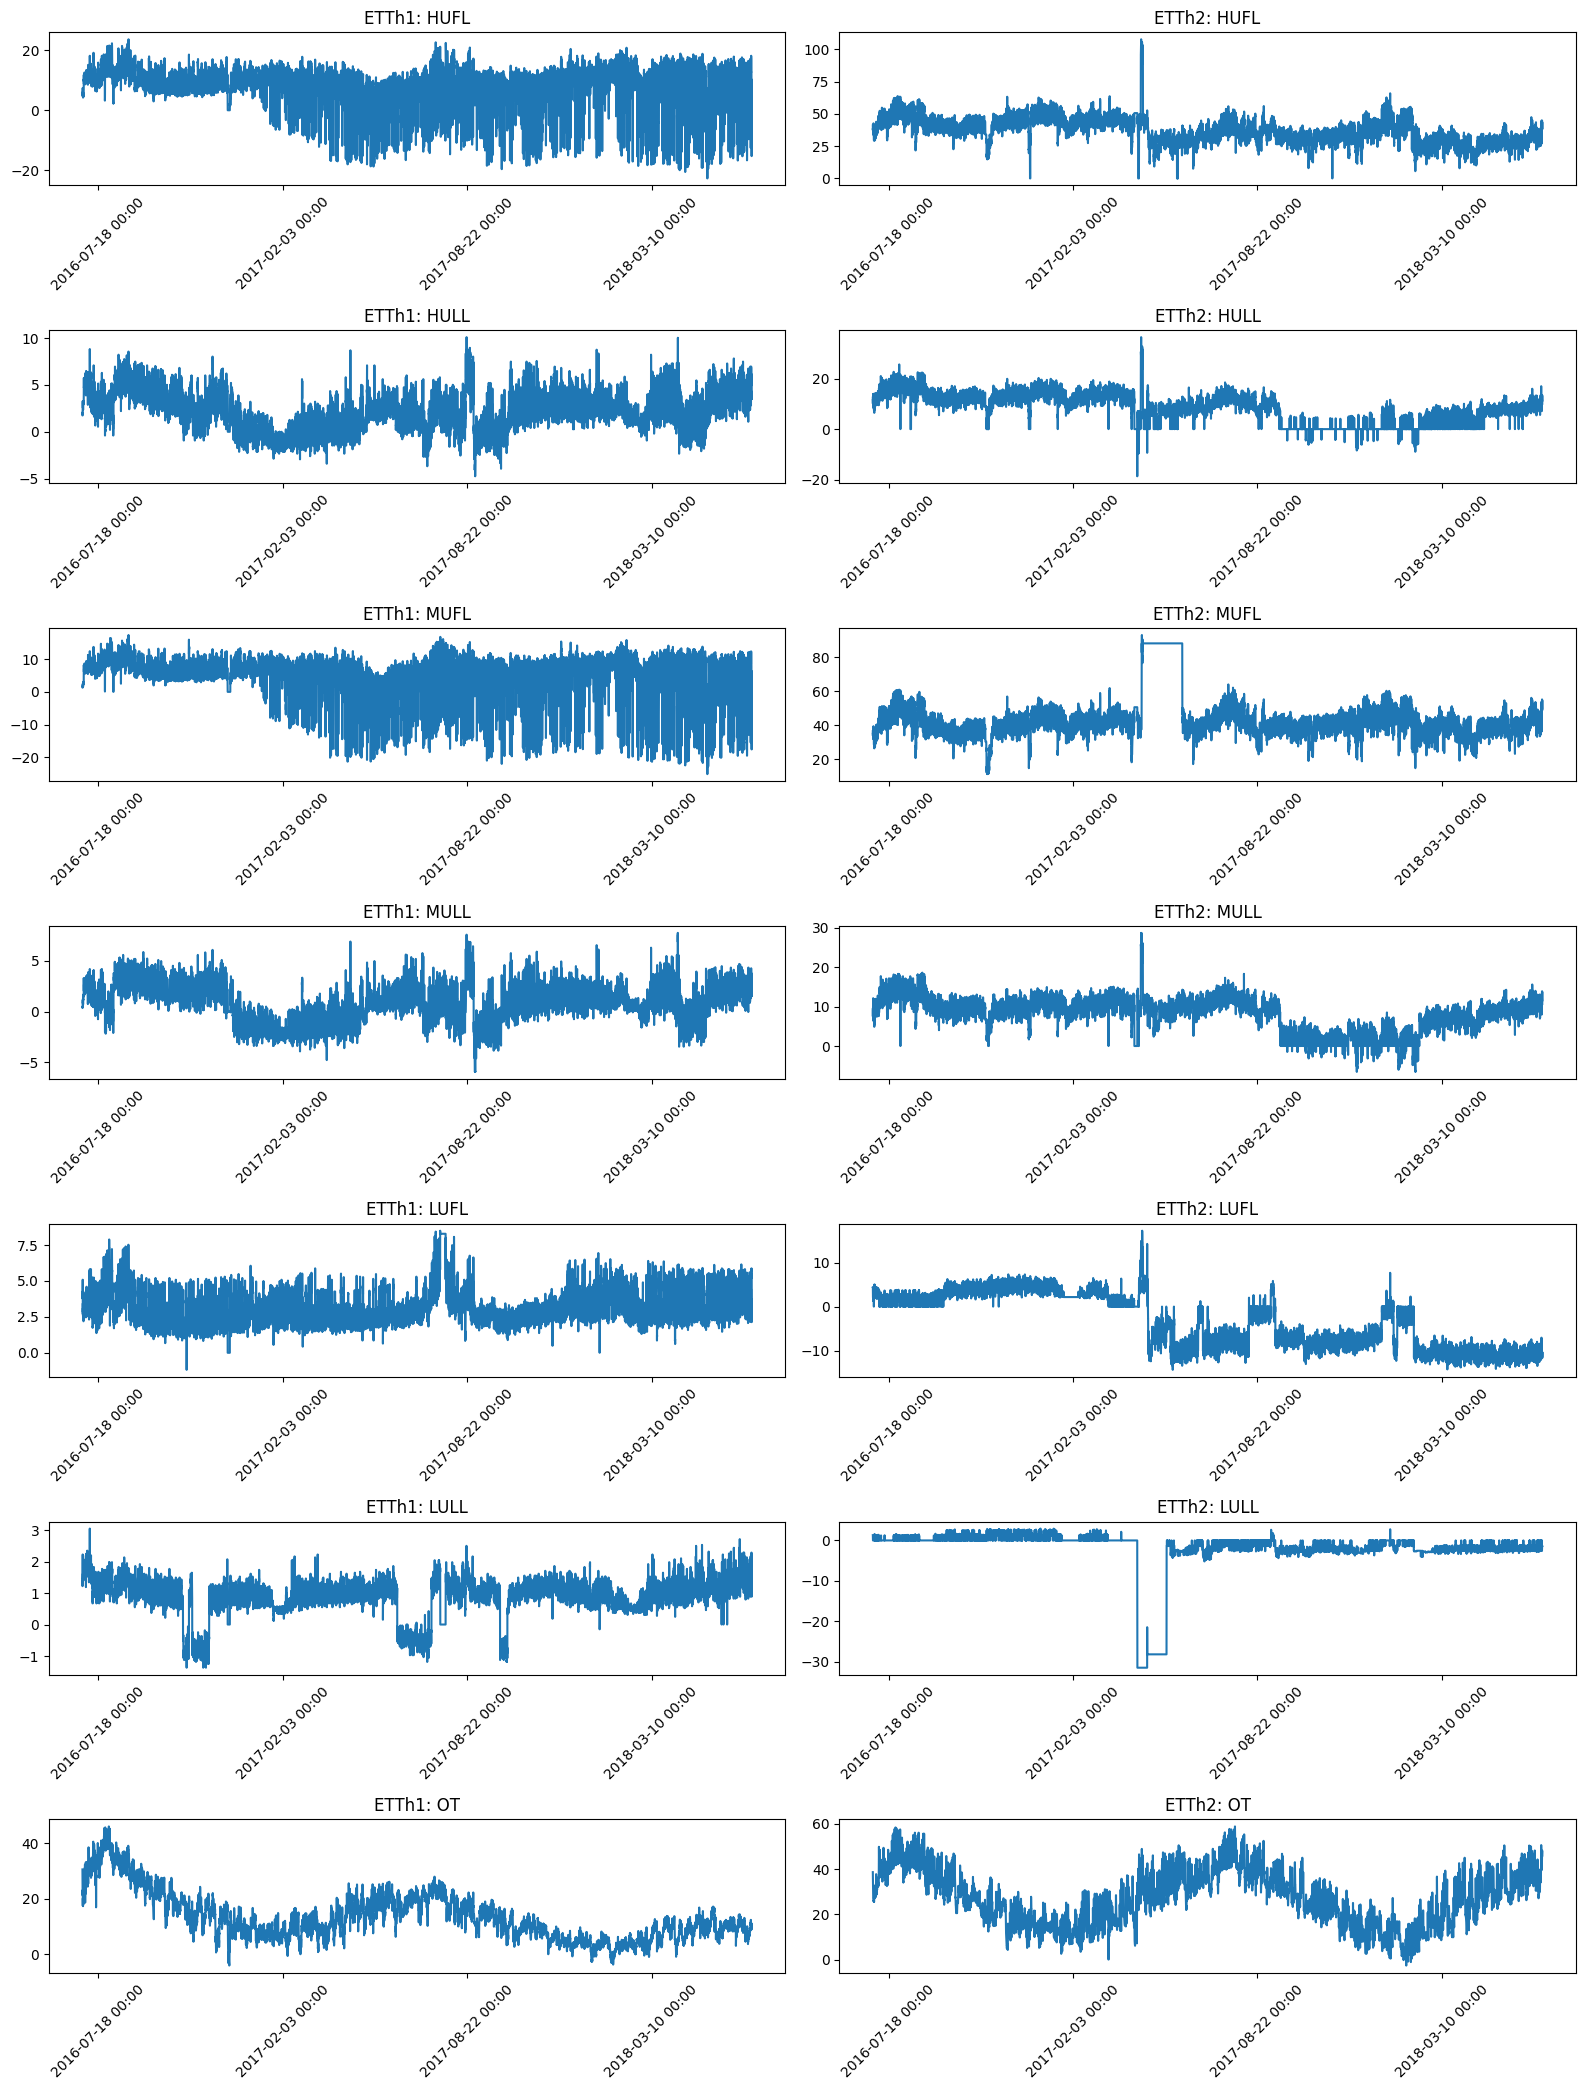

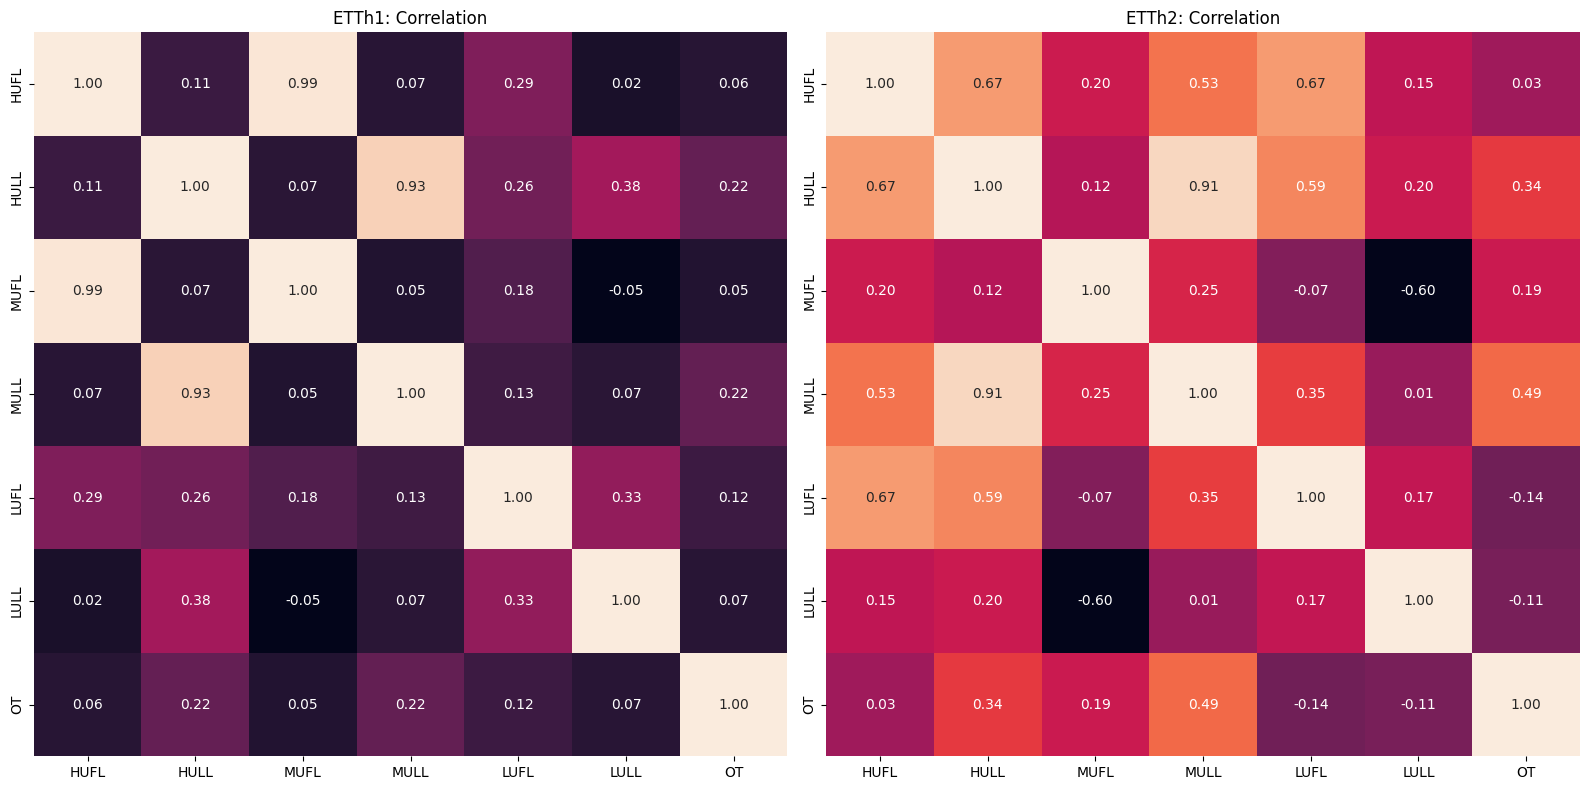

In [9]:
plot_timeseries([ETTh1, ETTh2], ['ETTh1', 'ETTh2'])

# Preprocess

In [3]:
ETTh1['date'] = pd.to_datetime(ETTh1['date'])
ETTh2['date'] = pd.to_datetime(ETTh2['date'])

ETTh1 = ETTh1.sort_values(by='date')
ETTh2 = ETTh2.sort_values(by='date')

ETTh1.to_csv('ETTh1_prepared.csv', index=False)
ETTh2.to_csv('ETTh2_prepared.csv', index=False)

# Optuna

In [15]:
def objective(trial):
    args = dotdict()
    
    # Фиксированные параметры
    args.model = 'informer'
    args.data = 'custom'
    args.root_path = './'
    args.data_path = 'ETTh1_prepared.csv'
    args.features = 'MS'
    args.target = 'OT'
    args.freq = 'h'
    args.checkpoints = './informer_checkpoints'
    args.d_model = 512
    args.d_layers = 2
    args.d_ff = 2048
    args.dropout = 0.05
    args.attn = 'prob'
    args.embed = 'timeF'
    args.activation = 'gelu'
    args.distil = True
    args.output_attention = False
    args.mix = True
    args.padding = 0
    args.batch_size = 32
    args.learning_rate = 0.0001
    args.loss = 'mse'
    args.lradj = 'type1'
    args.train_epochs = 6
    args.patience = 3
    args.num_workers = 0
    args.itr = 1
    args.des = 'optuna'
    args.use_amp = False
    
    # Используем обе GPU
    args.use_gpu = True
    args.use_multi_gpu = True
    args.devices = '0,1'
    args.device_ids = [0, 1]
    args.gpu = 0
    
    # Перебираемые параметры с constraint
    args.seq_len = trial.suggest_categorical('seq_len', [96, 168, 336, 480, 720])
    args.label_len = trial.suggest_categorical('label_len', [24, 48, 96])
    
    # label_len должен быть <= seq_len
    if args.label_len > args.seq_len:
        raise optuna.TrialPruned()
    
    args.pred_len = 24
    args.e_layers = trial.suggest_categorical('e_layers', [2, 3, 4, 6])
    args.n_heads = trial.suggest_categorical('n_heads', [8, 16])
    args.factor = trial.suggest_categorical('factor', [3, 5, 8, 10])
    
    args.enc_in = args.dec_in = 7
    args.c_out = 1
    args.detail_freq = args.freq
    args.freq = args.freq[-1:]
    
    exp = Exp_Informer(args)
    setting = f'informer_trial{trial.number}'
    
    exp.train(setting)
    exp.test(setting)
    
    metrics = np.load(f'./results/{setting}/metrics.npy')
    return metrics[1]

storage = JournalStorage(JournalFileBackend('./optuna.log'))

study = optuna.create_study(direction='minimize',
                            storage=storage,
                            study_name='no-name-0b753b49-ab85-4c6f-9f05-8f590532187c',
                            load_if_exists=True)
study.optimize(objective, n_trials=30)

print(f'Best MSE: {study.best_value:.4f}')
print(f'Best params: {study.best_params}')

[I 2025-10-02 20:49:12,526] Using an existing study with name 'no-name-0b753b49-ab85-4c6f-9f05-8f590532187c' instead of creating a new one.


Use GPU: cuda:0
train 12075
val 1719
test 3461
	iters: 100, epoch: 1 | loss: 0.2228181
	speed: 0.0835s/iter; left time: 180.5949s
	iters: 200, epoch: 1 | loss: 0.1274713
	speed: 0.0830s/iter; left time: 171.1468s
	iters: 300, epoch: 1 | loss: 0.1050589
	speed: 0.0835s/iter; left time: 163.9260s
Epoch: 1 cost time: 31.503942012786865
Epoch: 1, Steps: 377 | Train Loss: 0.1752585 Vali Loss: 0.4114709 Test Loss: 0.2022991
Validation loss decreased (inf --> 0.411471).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.1239584
	speed: 0.2147s/iter; left time: 383.4614s
	iters: 200, epoch: 2 | loss: 0.0925628
	speed: 0.0832s/iter; left time: 140.2077s
	iters: 300, epoch: 2 | loss: 0.0831694
	speed: 0.0827s/iter; left time: 131.1163s
Epoch: 2 cost time: 31.33404850959778
Epoch: 2, Steps: 377 | Train Loss: 0.0910598 Vali Loss: 0.3498452 Test Loss: 0.1217959
Validation loss decreased (0.411471 --> 0.349845).  Saving model ...
Updating learning rate to 5e-05
	iters

[I 2025-10-02 20:52:25,876] Trial 30 finished with value: 0.12132202088832855 and parameters: {'seq_len': 96, 'label_len': 48, 'e_layers': 2, 'n_heads': 16, 'factor': 10}. Best is trial 21 with value: 0.06791556626558304.


test shape: (108, 32, 24, 1) (108, 32, 24, 1)
test shape: (3456, 24, 1) (3456, 24, 1)
mse:0.12132202088832855, mae:0.2691488564014435
Use GPU: cuda:0
train 12075
val 1719
test 3461
	iters: 100, epoch: 1 | loss: 0.1152807
	speed: 0.0700s/iter; left time: 151.3592s
	iters: 200, epoch: 1 | loss: 0.1485210
	speed: 0.0701s/iter; left time: 144.6518s
	iters: 300, epoch: 1 | loss: 0.1703668
	speed: 0.0700s/iter; left time: 137.3307s
Epoch: 1 cost time: 26.37979483604431
Epoch: 1, Steps: 377 | Train Loss: 0.1601944 Vali Loss: 0.1764888 Test Loss: 0.0791888
Validation loss decreased (inf --> 0.176489).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.0677058
	speed: 0.1768s/iter; left time: 315.7477s
	iters: 200, epoch: 2 | loss: 0.0616241
	speed: 0.0699s/iter; left time: 117.8654s
	iters: 300, epoch: 2 | loss: 0.0820489
	speed: 0.0714s/iter; left time: 113.2619s
Epoch: 2 cost time: 26.577051401138306
Epoch: 2, Steps: 377 | Train Loss: 0.0887842 Vali Loss: 0.36

[I 2025-10-02 20:54:36,719] Trial 31 finished with value: 0.07919768244028091 and parameters: {'seq_len': 96, 'label_len': 24, 'e_layers': 2, 'n_heads': 16, 'factor': 3}. Best is trial 21 with value: 0.06791556626558304.


test shape: (108, 32, 24, 1) (108, 32, 24, 1)
test shape: (3456, 24, 1) (3456, 24, 1)
mse:0.07919768244028091, mae:0.22176803648471832
Use GPU: cuda:0
train 12075
val 1719
test 3461
	iters: 100, epoch: 1 | loss: 0.2009708
	speed: 0.0775s/iter; left time: 167.6285s
	iters: 200, epoch: 1 | loss: 0.1328133
	speed: 0.0752s/iter; left time: 155.1952s
	iters: 300, epoch: 1 | loss: 0.1321056
	speed: 0.0756s/iter; left time: 148.3767s
Epoch: 1 cost time: 28.742425680160522
Epoch: 1, Steps: 377 | Train Loss: 0.1678190 Vali Loss: 0.1822682 Test Loss: 0.0967812
Validation loss decreased (inf --> 0.182268).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.0834030
	speed: 0.1917s/iter; left time: 342.2907s
	iters: 200, epoch: 2 | loss: 0.0990961
	speed: 0.0781s/iter; left time: 131.5962s
	iters: 300, epoch: 2 | loss: 0.0581528
	speed: 0.0762s/iter; left time: 120.8376s
Epoch: 2 cost time: 28.887306928634644
Epoch: 2, Steps: 377 | Train Loss: 0.0916784 Vali Loss: 0.

[I 2025-10-02 20:56:58,547] Trial 32 finished with value: 0.09659630805253983 and parameters: {'seq_len': 96, 'label_len': 48, 'e_layers': 2, 'n_heads': 16, 'factor': 3}. Best is trial 21 with value: 0.06791556626558304.


test shape: (108, 32, 24, 1) (108, 32, 24, 1)
test shape: (3456, 24, 1) (3456, 24, 1)
mse:0.09659630805253983, mae:0.23784488439559937
Use GPU: cuda:0
train 12075
val 1719
test 3461
	iters: 100, epoch: 1 | loss: 0.1766659
	speed: 0.0699s/iter; left time: 151.2217s
	iters: 200, epoch: 1 | loss: 0.1286392
	speed: 0.0697s/iter; left time: 143.8089s
	iters: 300, epoch: 1 | loss: 0.1144597
	speed: 0.0702s/iter; left time: 137.8018s
Epoch: 1 cost time: 26.399787187576294
Epoch: 1, Steps: 377 | Train Loss: 0.1730201 Vali Loss: 0.2481261 Test Loss: 0.1370465
Validation loss decreased (inf --> 0.248126).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.1833174
	speed: 0.1771s/iter; left time: 316.3342s
	iters: 200, epoch: 2 | loss: 0.1484092
	speed: 0.0713s/iter; left time: 120.2291s
	iters: 300, epoch: 2 | loss: 0.0718507
	speed: 0.0700s/iter; left time: 111.0072s
Epoch: 2 cost time: 26.530093908309937
Epoch: 2, Steps: 377 | Train Loss: 0.0945545 Vali Loss: 0.

[I 2025-10-02 20:59:09,297] Trial 33 finished with value: 0.13684263825416565 and parameters: {'seq_len': 96, 'label_len': 24, 'e_layers': 2, 'n_heads': 16, 'factor': 3}. Best is trial 21 with value: 0.06791556626558304.


test shape: (108, 32, 24, 1) (108, 32, 24, 1)
test shape: (3456, 24, 1) (3456, 24, 1)
mse:0.13684263825416565, mae:0.29338181018829346
Use GPU: cuda:0
train 12075
val 1719
test 3461
	iters: 100, epoch: 1 | loss: 0.1472726
	speed: 0.0756s/iter; left time: 163.5981s
	iters: 200, epoch: 1 | loss: 0.2021285
	speed: 0.0758s/iter; left time: 156.3074s
	iters: 300, epoch: 1 | loss: 0.1411025
	speed: 0.0760s/iter; left time: 149.2522s
Epoch: 1 cost time: 28.59874439239502
Epoch: 1, Steps: 377 | Train Loss: 0.1891486 Vali Loss: 0.4321181 Test Loss: 0.1809302
Validation loss decreased (inf --> 0.432118).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.1197648
	speed: 0.1920s/iter; left time: 342.8422s
	iters: 200, epoch: 2 | loss: 0.1103455
	speed: 0.0759s/iter; left time: 127.9054s
	iters: 300, epoch: 2 | loss: 0.0856372
	speed: 0.0765s/iter; left time: 121.3339s
Epoch: 2 cost time: 28.850862741470337
Epoch: 2, Steps: 377 | Train Loss: 0.0937145 Vali Loss: 0.2

[I 2025-10-02 21:02:05,557] Trial 34 finished with value: 0.09455003589391708 and parameters: {'seq_len': 96, 'label_len': 48, 'e_layers': 2, 'n_heads': 16, 'factor': 3}. Best is trial 21 with value: 0.06791556626558304.


test shape: (108, 32, 24, 1) (108, 32, 24, 1)
test shape: (3456, 24, 1) (3456, 24, 1)
mse:0.09455003589391708, mae:0.23668110370635986
Use GPU: cuda:0
train 11451
val 1719
test 3461
	iters: 100, epoch: 1 | loss: 0.1661795
	speed: 0.3466s/iter; left time: 708.1545s
	iters: 200, epoch: 1 | loss: 0.1848451
	speed: 0.3495s/iter; left time: 679.0524s
	iters: 300, epoch: 1 | loss: 0.1599317
	speed: 0.3515s/iter; left time: 647.7272s
Epoch: 1 cost time: 124.8513400554657
Epoch: 1, Steps: 357 | Train Loss: 0.2080745 Vali Loss: 0.3032414 Test Loss: 0.2479837
Validation loss decreased (inf --> 0.303241).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.1591995
	speed: 0.8214s/iter; left time: 1384.8593s
	iters: 200, epoch: 2 | loss: 0.0816340
	speed: 0.3522s/iter; left time: 558.6677s
	iters: 300, epoch: 2 | loss: 0.0745486
	speed: 0.3503s/iter; left time: 520.5570s
Epoch: 2 cost time: 125.21952939033508
Epoch: 2, Steps: 357 | Train Loss: 0.1005275 Vali Loss: 0.

[W 2025-10-02 21:11:45,294] Trial 35 failed with parameters: {'seq_len': 720, 'label_len': 96, 'e_layers': 6, 'n_heads': 8, 'factor': 10} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_36/3789876841.py", line 63, in objective
    exp.train(setting)
  File "/kaggle/working/Informer2020/exp/exp_informer.py", line 173, in train
    loss.backward()
  File "/usr/local/lib/python3.11/dist-packages/torch/_tensor.py", line 626, in backward
    torch.autograd.backward(
  File "/usr/local/lib/python3.11/dist-packages/torch/autograd/__init__.py", line 347, in backward
    _engine_run_backward(
  File "/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py", line 823, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the 

KeyboardInterrupt: 

# LLAMBO

In [7]:
import os
import optuna
import optunahub

def objective(trial):
    args = dotdict()
    
    args.model = 'informer'
    args.data = 'custom'
    args.root_path = './'
    args.data_path = 'ETTh1_prepared.csv'
    args.features = 'MS'
    args.target = 'OT'
    args.freq = 'h'
    args.checkpoints = './informer_checkpoints'
    args.d_model = 512
    args.d_layers = 2
    args.d_ff = 2048
    args.dropout = 0.05
    args.attn = 'prob'
    args.embed = 'timeF'
    args.activation = 'gelu'
    args.distil = True
    args.output_attention = False
    args.mix = True
    args.padding = 0
    args.batch_size = 32
    args.learning_rate = 0.0001
    args.loss = 'mse'
    args.lradj = 'type1'
    args.train_epochs = 6
    args.patience = 3
    args.num_workers = 0
    args.itr = 1
    args.des = 'optuna'
    args.use_amp = False
    
    args.use_gpu = True
    args.use_multi_gpu = True
    args.devices = '0,1'
    args.device_ids = [0, 1]
    args.gpu = 0
    
    args.seq_len = trial.suggest_int('seq_len', 96, 720)
    args.label_len = trial.suggest_int('label_len', 24, 96)
    
    if args.label_len > args.seq_len:
        raise optuna.TrialPruned()
    
    args.pred_len = 24
    args.e_layers = trial.suggest_int('e_layers', 2, 6)
    args.n_heads = trial.suggest_int('n_heads', 8, 16)
    args.factor = trial.suggest_int('factor', 3, 10)
    
    args.enc_in = args.dec_in = 7
    args.c_out = 1
    args.detail_freq = args.freq
    args.freq = args.freq[-1:]
    
    exp = Exp_Informer(args)
    setting = f'informer_trial{trial.number}'
    
    exp.train(setting)
    exp.test(setting)
    
    metrics = np.load(f'./results/{setting}/metrics.npy')
    return metrics[1]


module = optunahub.load_module("samplers/llambo")
sampler = module.LLAMBOSampler(
    custom_task_description="""Optimize Informer model for time series forecasting on ETTh1 dataset. 
    Parameters: seq_len (input window), label_len (overlap), e_layers (encoder depth), 
    n_heads (attention heads), factor (ProbSparse factor). 
    Constraint: label_len <= seq_len. Minimize MSE.""",
    sm_mode="generative",
    api_key=OPENAI_Key_Sasha,
    model="gpt-4o-mini",
    n_initial_samples=0
)

storage = JournalStorage(JournalFileBackend('./optuna_LLM.log'))
study = optuna.create_study(direction='minimize', sampler=sampler, 
                            storage=storage, study_name='gpt4_mini_study',
                            load_if_exists=True)
study.optimize(objective, n_trials=6)
print(f'Best MSE: {study.best_value:.4f}')
print(f'Best params: {study.best_params}')

[I 2025-10-03 07:45:30,875] Using an existing study with name 'gpt4_mini_study' instead of creating a new one.


Generated 0 initial configurations.
Setting inter-component delay of 0.60 seconds based on rate limit
Rate limiter initialized: 100 requests/minute (0.60s between requests)
Rate limiter initialized: 100 requests/minute (0.60s between requests)
[Minimization] Desired fval: 0.093992 (best: 0.113181, range: 0.191890, adjusted alpha: 0.1)
EXAMPLE ACQUISITION PROMPT
There is a black-box optimization task. Below is a description of the task:
Optimize Informer model for time series forecasting on ETTh1 dataset. 
    Parameters: seq_len (input window), label_len (overlap), e_layers (encoder depth), 
    n_heads (attention heads), factor (ProbSparse factor). 
    Constraint: label_len <= seq_len. Minimize MSE.
The allowable ranges for the hyperparameters are:
- e_layers: [2, 6] (int)
- factor: [3, 10] (int)
- label_len: [24, 96] (int)
- n_heads: [8, 16] (int)
- seq_len: [96, 720] (int)
Recommend a configuration that can achieve the target performance of 0.093992. Do not recommend values at the 

[I 2025-10-03 07:48:44,181] Trial 7 finished with value: 0.15412172675132751 and parameters: {'seq_len': 160, 'label_len': 24, 'e_layers': 2, 'n_heads': 12, 'factor': 4}. Best is trial 0 with value: 0.11318136006593704.


test shape: (108, 32, 24, 1) (108, 32, 24, 1)
test shape: (3456, 24, 1) (3456, 24, 1)
mse:0.15412172675132751, mae:0.3095754086971283
Generated 0 initial configurations.
[Minimization] Desired fval: 0.093992 (best: 0.113181, range: 0.191890, adjusted alpha: 0.1)
EXAMPLE ACQUISITION PROMPT
There is a black-box optimization task. Below is a description of the task:
Optimize Informer model for time series forecasting on ETTh1 dataset. 
    Parameters: seq_len (input window), label_len (overlap), e_layers (encoder depth), 
    n_heads (attention heads), factor (ProbSparse factor). 
    Constraint: label_len <= seq_len. Minimize MSE.
The allowable ranges for the hyperparameters are:
- e_layers: [2, 6] (int)
- factor: [3, 10] (int)
- label_len: [24, 96] (int)
- n_heads: [8, 16] (int)
- seq_len: [96, 720] (int)
Recommend a configuration that can achieve the target performance of 0.093992. Do not recommend values at the minimum or maximum of allowable range, do not recommend rounded values. Re

[W 2025-10-03 07:54:21,663] Trial 8 failed with parameters: {'seq_len': 720, 'label_len': 96, 'e_layers': 6, 'n_heads': 14, 'factor': 6} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_36/3704375253.py", line 63, in objective
    exp.train(setting)
  File "/kaggle/working/Informer2020/exp/exp_informer.py", line 173, in train
    loss.backward()
  File "/usr/local/lib/python3.11/dist-packages/torch/_tensor.py", line 626, in backward
    torch.autograd.backward(
  File "/usr/local/lib/python3.11/dist-packages/torch/autograd/__init__.py", line 347, in backward
    _engine_run_backward(
  File "/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py", line 823, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C

KeyboardInterrupt: 

In [ ]:
print('Предсказание...')
preds = exp.predict(setting, load=True)

print(f'Готово! Результаты в ./results/{setting}/')